In [1]:
from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    backtesting_forecaster_multiseries,
)

from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor

from src.data import load_training_data, make_exog_features, split_data

In [2]:
data = load_training_data()
data = make_exog_features(data)
data.head()

,ba_AECI,ba_AVA,ba_AZPS,ba_BANC,ba_BPAT,ba_CHPD,ba_CISO,ba_CPLE,ba_CPLW,ba_DOPD,...,ba_TPWR,ba_TVA,ba_WACM,ba_WALC,ba_WAUW,exog_is_holiday,exog_month,exog_day_of_week,exog_is_weekend,exog_season
datetime,,,,,,,,,,,,,,,,,,,,,
2022-10-01,51628.0,27070.0,96193.0,46398.0,123905.0,3745.0,592567.0,123640.0,11797.0,4617.0,...,10804.0,348678.0,80299.0,24633.0,1820.0,0,10,5,1,4
2022-10-02,53127.0,28039.0,97208.0,42814.0,125317.0,3655.0,560074.0,124418.0,11759.0,4583.0,...,10773.0,345900.0,79702.0,26100.0,1749.0,0,10,6,1,4
2022-10-03,54708.0,30110.0,96570.0,47041.0,133353.0,3790.0,623658.0,132803.0,12155.0,4732.0,...,11228.0,373596.0,80536.0,25310.0,1915.0,0,10,0,0,4
2022-10-04,53345.0,30764.0,88963.0,48332.0,134664.0,3831.0,654561.0,134430.0,12294.0,4829.0,...,10927.0,378071.0,80522.0,23938.0,1838.0,0,10,1,0,4
2022-10-05,53356.0,30421.0,91984.0,50362.0,135464.0,3815.0,664304.0,136348.0,12482.0,4854.0,...,10962.0,376763.0,81362.0,23839.0,1828.0,0,10,2,0,4


In [3]:
# Encoding exog features as categorical for training
data = data.astype({col: "category" for col in data.filter(like="exog_").columns})

In [4]:
data_train, data_test = split_data(data)

data_train.shape=(396, 58)
data_test.shape=(366, 58)
Train dates : 2022-10-01 00:00:00 --- 2023-10-31 00:00:00   (n=396)
Test dates  : 2023-11-01 00:00:00 --- 2024-10-31 00:00:00   (n=366)


In [ ]:
# Setting up forecaster
forecaster = ForecasterRecursiveMultiSeries(
    regressor=LGBMRegressor(random_state=123, verbose=-1, categorical_feaure=data_train.filter(like='exog_').columns.tolist()),
    lags=[*range(1, 183)],
    window_features=RollingFeatures(
        stats=["mean", "mean", "mean", "mean", "std", "std", "std", "std"],
        window_sizes=[7, 30, 182, 365, 7, 30, 182, 365],
    ),  # Rolling means and stds for 1w, 1m, 6m, 12m
    encoding="ordinal",
    transformer_series=StandardScaler(),  # Transforms each target series using standard scaler. Tranformations are applied under the hood when predicting and the prediction itself is returned on the original scale.
    transformer_exog=StandardScaler(),
)

In [27]:
# Setting up validation
cv = TimeSeriesFold(
    steps=1, 
    initial_train_size=len(data_train),
    refit=True,
    fixed_train_size=False,
    allow_incomplete_fold=True,
)

In [28]:
metrics, backtest_predictions = (
    backtesting_forecaster_multiseries(
        forecaster=forecaster,
        series=data.filter(like="ba_"),
        exog=data.filter(like="exog_"),
        cv=cv,
        levels=None,
        metric="mean_absolute_error",
        add_aggregated_metric=True,
        n_jobs="auto",
        verbose=False,
        show_progress=True,
        suppress_warnings=False,
    )
)

/Users/douglaslazenby/Documents/Projects/energy-demand-forecasting/.venv/lib/python3.11/site-packages/skforecast/model_selection/_validation.py:638: LongTrainingWarning: The forecaster will be fit 366 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


  0%|          | 0/366 [00:00<?, ?it/s]

In [29]:
metrics[metrics['levels'] == 'average']

,levels,mean_absolute_error
53,average,7503.56686


This is better than the naive baseline we established. 

Now do a quick check of feature importances.

In [30]:
forecaster.fit(
    series=data.filter(like="ba_"),
    exog=data.filter(like="exog_"),
)

forecaster.get_feature_importances()

,feature,importance
0,lag_1,280
193,exog_day_of_week,142
1,lag_2,78
186,roll_std_7,37
5,lag_6,36
...,...,...
170,lag_171,3
71,lag_72,2
190,_level_skforecast,1
134,lag_135,0


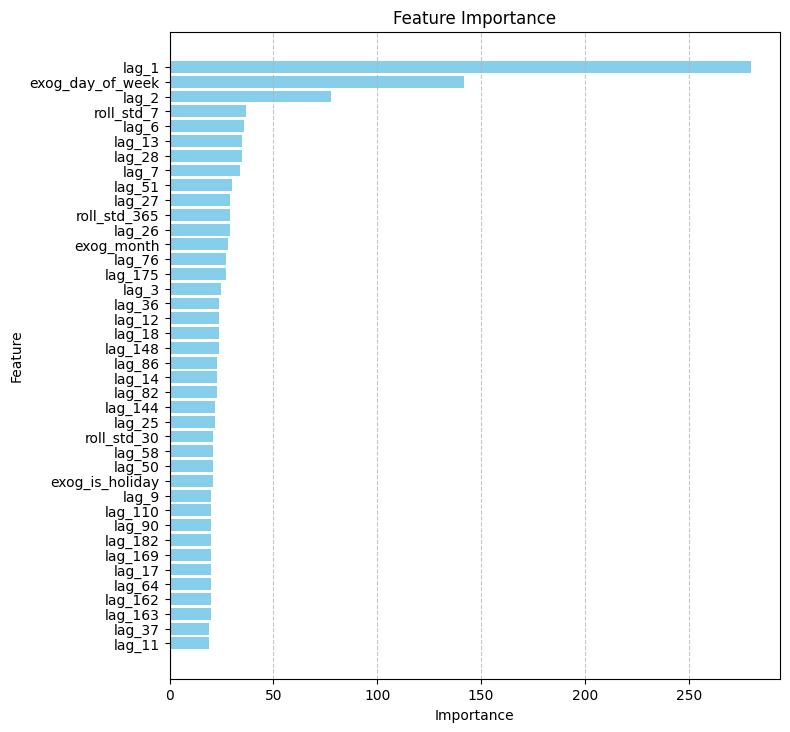

In [41]:
import matplotlib.pyplot as plt

df = forecaster.get_feature_importances().nlargest(40, columns='importance')
df = df.sort_values(by="importance", ascending=True)

# Plotting
plt.figure(figsize=(8, 5))
plt.barh(df["feature"], df["importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.gcf().set_size_inches(8, len(df) * 0.2)
plt.show()